<a href="https://colab.research.google.com/github/jsedoc/ConceptorDebias/blob/master/Experiments/Conceptors/Understanding_Conceptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction To Conceptors
More on conceptors can be found here: <br>
<https://arxiv.org/pdf/1403.3369.pdf>  <br>
<https://arxiv.org/pdf/1406.2671.pdf>

In [0]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse as ellipse
from sklearn.datasets import make_spd_matrix as random_semipositivedefinite
from IPython.display import Math, HTML
import matplotlib.transforms as transforms
%matplotlib inline

## Listing Of Functions Defined In This Notebook

In [0]:
# get_conceptor(x, alpha) returns the conceptor matrix associated with dataset x
# when using aperture alpha

def get_conceptor(x, alpha):    
    N = x.shape[1] - 1
    cov = (x @ x.T)*(1/N)
    return cov @ inv(cov + (1/alpha**2)*np.eye(x.shape[0]))

def improved_conceptor(X, alpha = 1):
    N = X.shape[1] 
    means = np.mean(X, axis = 1)
    X = X - means[:,None]
    cov = (X @ X.T)*(1/N)
    return cov @ inv(cov + (alpha**(-2))*np.eye(X.shape[0]))

# corr(x) returns the correlation matrix for the dataset x
def corr(x):
    k = x.shape[1] - 1
    means = np.mean(x, axis = 1)
    std = np.sqrt(np.var(x, axis = 1))
    x = (x - means[:,None])/std[:,None]
    return (x @ x.T)*(1/k)

# Functions corresponding to boolean operations applied to conceptors
def NOT(C):
    return np.eye(C.shape[0]) - C

def AND(C1,C2):
    return inv((inv(C1) + inv(C2) - np.eye(x.shape[0])))

def OR(C1,C2):
    return NOT(AND(NOT(C1),NOT(C2)))

# Returns the rotation associated with a conceptor
def theta(vec):
    return np.arccos(np.dot(vec[:,0]*(np.sign(vec[0,0])*np.sign(vec[1,0])),[1,0]))

# Returns the ellipse associated with the conceptor in the chosen color
def CtoE(C, color = 'r'):
    eig,vec = np.linalg.eig(C)
    O = theta(vec)
    return ellipse((0,0), 2*eig[0], 2*eig[1], np.rad2deg(O), edgecolor = 'color', facecolor = 'none')

# 1) What is a Conceptor?


## Ellipsoid clouds can capture patterns in data <br>
Consider a set of data points $X_{i}$ in $R^{n}$. When we compute the covariance matrix for this set of data points, we end up with a matrix $M$ which has eigenvectors and eigenvalues corresponding to the principle directions of variation in the data as well as the amount of variation in that direction. We can visualize $M$ as an ellipsoid $E$ where the directions and lengths of the principal axes of the ellipsoid correspond the the eigenvectors and eigenvalues of $M$. For an appropriate set of data $X$, $E$ can be a good representation of the overall pattern defined by $X$ in $R^{n}$. In this section, we will create a dataset in $R^{2}$ and compute its corresponding ellipsoid representation. 


First lets create a cloud of data points and visualize it.


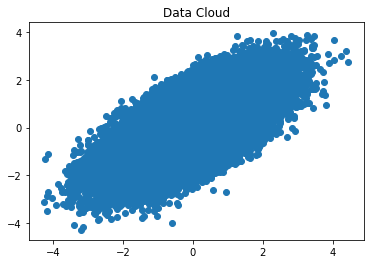



Covariance Matrix of X
[[0.99592607 0.69624873]
 [0.69624873 0.99545987]]


Eigenvalues
[1.69194174 0.2994442 ]


Eigenvectors
[[ 0.70722514 -0.7069884 ]
 [ 0.7069884   0.70722514]]


Now we can plot the ellipse caputred by the eigenvalues.
Here we plot several ellipses with the same principal directions and centers 
but we allow them to scale by multiples of the eigenvalues of the covariance 
matrix previously computed.


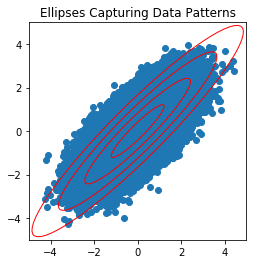

In [0]:
################################################################################
## First lets create a cloud of data points and visualize it.                 ##  
################################################################################
print('First lets create a cloud of data points and visualize it.')
num_samples = 100000
covariance = [[1,0.7],
              [0.7,1]]
X = np.random.multivariate_normal([0,0],covariance,num_samples).T
plt.title('Data Cloud')
plt.scatter(X[0],X[1])
plt.show()
print("\n")


################################################################################
## The covariance matrix can be calcualted to be X * X.T                      ##
################################################################################
M = (X @ X.T)*(1/X.shape[1])
print("Covariance Matrix of X")
print(M)
print("\n")


################################################################################
## We can then compute the eigenvalues and eigenvectors of this matrix        ##
################################################################################
eig,vec = np.linalg.eig(M)
print("Eigenvalues")
print(eig)
print("\n")
print("Eigenvectors")
print(vec)
print("\n")


################################################################################
## We can now plot the corresponding ellipses                                 ##
################################################################################
print('Now we can plot the ellipse caputred by the eigenvalues.')
print('Here we plot several ellipses with the same principal directions and centers \nbut we allow them to scale by multiples of the eigenvalues of the covariance \nmatrix previously computed.')

theta = np.arccos(np.dot(vec[:,0],[1,0]))
ax = plt.subplot(111, aspect = 'equal')
plt.title('Ellipses Capturing Data Patterns')
ax.scatter(X[0],X[1])
for i in range(4):
    c = 'r'
    ell = ellipse((0,0), (i+1)*2*eig[0], (i+1)*2*eig[1], np.rad2deg(theta), edgecolor = c, facecolor = 'none')
    ax.add_artist(ell)
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.show()

## From Ellipsoids To Conceptors <br>
Ellipsoids allows us to capture patterns in data in a convenient matrix representation. However, one problem with this representation is the fact that the eigenvalues are unbounded. The conceptor matrix is a way to alleviate this issue. The conceptor matrix $C$ is a matrix that has the same eigenvectors as $M$, however, the corresponding eigenvalues are scaled in the following way $$\lambda_{new} = \frac{\lambda_{old}}{\lambda_{old}+\alpha^{-2}}$$
The parameter $\alpha$ is called the "apterture" and can be defined by the researcher. We will leave careful examination of $\alpha$ for future sections. In this section, we do a visualization of the original ellipse generated by $M$ as well as the associated ellipse generated by $C$. The conceptor matrix captures the same relationship as the covariance matrix $M$, however its representative ellipsoid is always contained in the unit sphere. 

Our original ellipse may not lie within the unit circle.


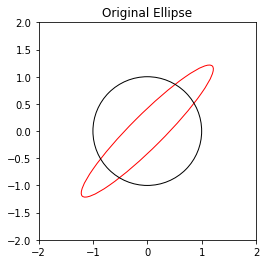

Lets transform our covariance matrix into its associated conceptor matrix
Original Singular Values
[1.69194174 0.2994442 ]


Modified Singular Values
Modified Singular Values
[0.62852094 0.23044021]


Conceptor Matrix
[[0.42954721 0.19904035]
 [0.19904035 0.42941394]]


The conceptor's ellipse is indeed contained in the unit circle!


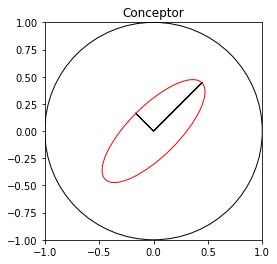

In [0]:
################################################################################
## Notice that our original Ellipse does not lie within the unit circle       ##
################################################################################
print('Our original ellipse may not lie within the unit circle.')
theta = np.arccos(np.dot(vec[:,0],[1,0]))
eig,vec = np.linalg.eig(M)
ax = plt.subplot(111, aspect = 'equal')
plt.title('Original Ellipse')
ell = ellipse((0,0), 2*eig[0], 2*eig[1], np.rad2deg(theta), edgecolor = 'r', facecolor = 'none')
circ = ellipse((0,0),2,2, edgecolor = 'k', facecolor = 'none')
ax.add_artist(ell)
ax.add_artist(circ)
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.show()


################################################################################
# Lets transform our covariance matrix into its associated conceptor matrix   ##
################################################################################
alpha = 1
print("Lets transform our covariance matrix into its associated conceptor matrix")
print("Original Singular Values")
print(eig)
print("\n")
for i in range(eig.size):
    eig[i] = eig[i]/(eig[i]+alpha**(-2))

    print("Modified Singular Values")
print(eig)
print("\n")

# Returns the matrix associated with the given eigenvalues and eigenvectors
def eigToMat(eig,vec):
    D = np.diag(eig)
    return np.matmul(vec,np.matmul(D,inv(vec)))

C = eigToMat(eig,vec)
print("Conceptor Matrix")
print(C)
print("\n")


################################################################################
## We can then observe that the conceptor matrix's ellipse is ineed contained ##
## in the unit circle, as we would like it to be                              ##
################################################################################
print("The conceptor's ellipse is indeed contained in the unit circle!")
ax = plt.subplot(111, aspect = 'equal')
plt.title('Conceptor')
ell = ellipse((0,0), 2*eig[0], 2*eig[1], np.rad2deg(theta), edgecolor = 'r', facecolor = 'none')
circ = ellipse((0,0),2,2, edgecolor = 'k', facecolor = 'none')
first = plt.arrow(0,0,eig[0]*vec[0,0],eig[0]*vec[1,0])
second = plt.arrow(0,0,eig[1]*vec[0,1],eig[1]*vec[1,1])
ax.add_artist(first)
ax.add_artist(second)
ax.add_artist(ell)
ax.add_artist(circ)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

## More Efficient Computation
It turns out that there is a more efficient way to compute conceptor matrices! In this section we provide a simple implementation of this method for use in subsequent section. 

In [0]:
# get_conceptor(x, alpha) returns the conceptor matrix associated with dataset x
# when using aperture alpha assuming mean 0 

def get_conceptor(x, alpha):
    N = x.shape[1] - 1
    cov = (x @ x.T)*(1/N)
    return cov @ inv(cov + (1/alpha**2)*np.eye(x.shape[0]))

## Using Conceptors For Debiasing

It turns out that we can use conceptors for debiasing by computing the negated conceptor $\neg C$ and applying to the original data. In this section, we will simply demonstrate what this looks like. We will further examine the idea of conceptor negation in future sections. 

After debiasing, the eccentricity of the data is significantly reduced


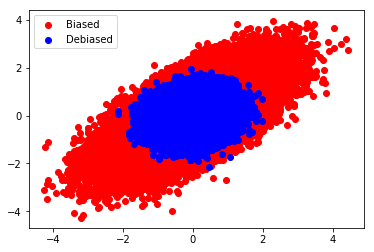

We can also examine the correlation matrices of the data before and after
we apply conceptor debiasing to it. 

Correlation of original data
[[1.00001   0.6992686]
 [0.6992686 1.00001  ]] 

Correlation of transformed data
[[1.00001    0.13666888]
 [0.13666888 1.00001   ]] 

Notice how the correlation of the transformed data looks much more like
the identity matrix


In [0]:
################################################################################
## First we compute the negated conceptor and apply it to our data            ##
################################################################################
notC = np.identity(2) - C
debiased = notC @ X

################################################################################
## Lets plot the data before and after to see how it changed                  ##
################################################################################
print('After debiasing, the eccentricity of the data is significantly reduced')
plt.scatter(X[0],X[1], c = 'r')
plt.scatter(debiased[0],debiased[1], c = 'b')
plt.legend(['Biased','Debiased'])
plt.show()

################################################################################
## We can also examine their correlation matrices                             ##
################################################################################

# corr(x) returns the correlation matrix for the dataset x
def corr(x):
    k = x.shape[1] - 1
    means = np.mean(x, axis = 1)
    std = np.sqrt(np.var(x, axis = 1))
    x = (x - means[:,None])/std[:,None]
    return (x @ x.T)*(1/k)
    
print('We can also examine the correlation matrices of the data before and after')
print('we apply conceptor debiasing to it. \n')
print('Correlation of original data')
print(corr(X), '\n')
print('Correlation of transformed data')
print(corr(debiased), '\n')
print('Notice how the correlation of the transformed data looks much more like')
print('the identity matrix')

# 2) Boolean Operations On Conceptors

## Defining Boolean Operations On Conceptors
We can define boolean operations on conceptors in the following way

$$\neg C := I - C$$
$$C \wedge C' := (C^{-1}+B^{-1}-I)^{-1}$$
$$C \vee C' := \neg(\neg C \wedge \neg C')$$

Where $\wedge$ denotes the AND operator and $\vee$ denotes the OR operator. It is not too difficult to confirm that these operations follow the laws of boolean logic. In this section we implement functions corresponding to these operations and explore exactly what they do. 

In [0]:
# Functions corresponding to boolean operations applied to conceptors
def NOT(C):
    return np.eye(C.shape[0]) - C

def AND(C1,C2):
    return inv((inv(C1) + inv(C2) - np.eye(C1.shape[0])))

def OR(C1,C2):
    return NOT(AND(NOT(C1),NOT(C2)))

## Understanding the $\neg$ Operator
The conceptor matrix $\neg C$ can be thought of as the unique conceptor with the following properties

1.   $C$ and $\neg C$ have the same eigenvectors
2.   For each eigenvector $v$ of $C$ and its corresponding eigenvalue $\lambda$, the eigenvalue of $\neg C$ corresponding to $v$ is $1- \lambda$

If a conceptor $C$ captures a patter $P$ in the data, then $\neg C$ represents a pattern $P'$ which has high variance in the directions where $P$ has low variance and low variance in the directions where $P$ has high variance. In this section we do a confirmation of these properties, both visually and numerically.



First we create a dataset


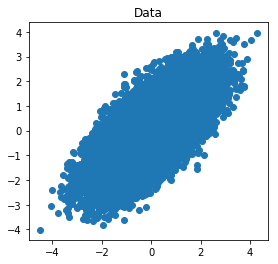

Then we can visualize the conceptor and negated conceptor


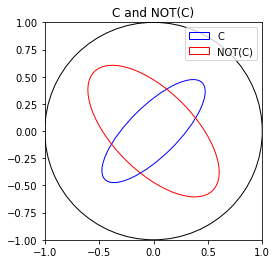


We can also examine their eigenvalues/eigenvectors 

Eigenvalues of C
[0.63071075 0.22876656] 

Eigenvalues of NOT(C)
[0.36928925 0.77123344] 

Eigenvectors of C
[[ 0.70822504 -0.70598675]
 [ 0.70598675  0.70822504]] 

Eigenvectors of NOT(C)
[[ 0.70822504 -0.70598675]
 [ 0.70598675  0.70822504]] 

Eigenvalues of C + Eigenvalues of NOT(C)
[1. 1.] 

Note that they have the same eigenvectors and their eigenvalues sum to 1


In [0]:
################################################################################
## First we create a dataset and associated conceptors                        ##
################################################################################
N = 50000
X = np.random.multivariate_normal([0,0],[[1,0.7],
                                         [0.7,1]],N).T
C = get_conceptor(X, 1)
notC = NOT(C)

eig_C,vec_C = np.linalg.eig(C)
eig_notC,vec_notC = np.linalg.eig(notC)

print('First we create a dataset')
ax = plt.subplot(111, aspect = 'equal')
plt.title('Data')
plt.scatter(X[0],X[1])
plt.show()

################################################################################
## Then we can plot the conceptor and negated conceptor                       ##
################################################################################
def thet(vec):
    temp = np.sign(vec[0,0])*np.sign(vec[1,0])*np.arccos(np.dot(vec[:,0],[1,0]))
    if abs(temp) > np.pi/2:
        temp = -temp
    return temp

def CtoE(C, color = 'r'):
    eig,vec = np.linalg.eig(C)
    O = thet(vec)
    ell = ellipse((0,0), 2*eig[0], 2*eig[1], np.rad2deg(O), edgecolor = color, facecolor = 'none')
    return ell

print('Then we can visualize the conceptor and negated conceptor')
ax = plt.subplot(111, aspect = 'equal')
plt.title('C and NOT(C)')

ell_C = CtoE(C, color = 'b')
ell_notC = CtoE(notC, color = 'r')
circ = CtoE(np.eye(2), color = 'k')
plt.legend([ell_C,ell_notC],['C','NOT(C)'])


ax.add_artist(ell_C)
ax.add_artist(ell_notC)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

################################################################################
## Finally, we can also examine their eigenvalues and eigenvectors            ##
################################################################################
print('\nWe can also examine their eigenvalues/eigenvectors \n')
print('Eigenvalues of C')
print(eig_C, '\n')
print('Eigenvalues of NOT(C)')
print(eig_notC, '\n')
print('Eigenvectors of C')
print(vec_C, '\n')
print('Eigenvectors of NOT(C)')
print(vec_notC*(-1), '\n')

print('Eigenvalues of C + Eigenvalues of NOT(C)')
print(eig_C + eig_notC, '\n')
print('Note that they have the same eigenvectors and their eigenvalues sum to 1')

## Understanding the $\wedge$ and $\vee$ Operators
We can think the AND and OR operations intuitively in the following ways: <br>
The AND operation ($\wedge$) takes two conceptors , $C$ and $C'$, and computes conceptor $\tilde{C}$ such that the ellipsoid representing $\tilde{C}$ is the largest ellipsoid contained in the intersection of the ellipsoid representations of $C$ and $C'$. <br>
The OR operation ($\vee$) takes two conceptors , $C$ and $C'$, and computes conceptor $\tilde{C}$ such that the ellipsoid representing $\tilde{C}$ is the smallest ellipsoid containing the ellipsoid representations of both $C$ and $C'$. <br>
In the following section we will visualize the AND and OR operators to confirm these properties!

First we generate two different clouds of data


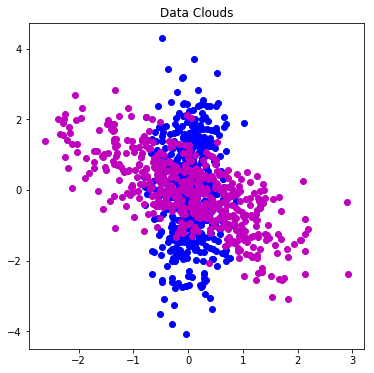



Then we can plot the associated conceptors


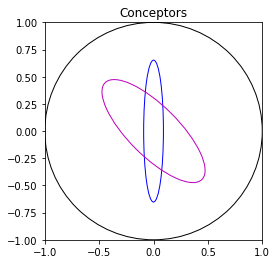

Now we can plot the AND conceptor (red)


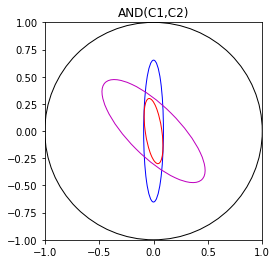

We can also plot the OR conceptor (red)


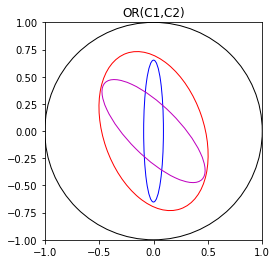

In [0]:
################################################################################
## First we create a dataset and associated conceptors                        ##
################################################################################
print('First we generate two different clouds of data')
N = 50000
r = np.pi/4
rot = [[np.cos(r), -np.sin(r)],[np.sin(r),np.cos(r)]]
X = np.random.multivariate_normal([0,0],[[1,0.9],
                                         [0.9,1]],N).T
Y = np.random.multivariate_normal([0,0],[[1,-0.7],
                                         [-0.7,1]],N).T
X = rot @ X

plt.figure(figsize=(6,6))
plt.title('Data Clouds')
plt.scatter(X[0][::100],X[1][::100], c = 'b')
plt.scatter(Y[0][::100],Y[1][::100], c = 'm')
plt.show()
print("\n")

################################################################################
## Then we can compute and plot conceptors for each dataset                   ##
################################################################################
C1 = get_conceptor(X,1)
C2 = get_conceptor(Y,1)

print('Then we can plot the associated conceptors')
ax = plt.subplot(111, aspect = 'equal')
ell1 = CtoE(C1, color = 'b')
ell2 = CtoE(C2, color = 'm')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title('Conceptors')
plt.show()

################################################################################
## Now we can compute and plot the AND and OR conceptors                      ##
################################################################################
print('Now we can plot the AND conceptor (red)')
ax = plt.subplot(111, aspect = 'equal')

ell1 = CtoE(C1, color = 'b')
ell2 = CtoE(C2, color = 'm')
ellAnd = CtoE(AND(C1,C2),color = 'r')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(ellAnd)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title('AND(C1,C2)')
plt.show()

print('We can also plot the OR conceptor (red)')
ax = plt.subplot(111, aspect = 'equal')

ell1 = CtoE(C1, color = 'b')
ell2 = CtoE(C2, color = 'm')
ellOR = CtoE(OR(C1,C2),color = 'r')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(ellOR)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title('OR(C1,C2)')
plt.show()

## Comparing OR and Unions

One question we can ask is whether $C \vee C' = \tilde{C}$ if $\tilde{C}$ is computed over the union of the datasets that $C$ and $C'$ are computed over. In general this is false. In this section we will do a short examination of how this is.

First we consider the case where |X| = |Y|


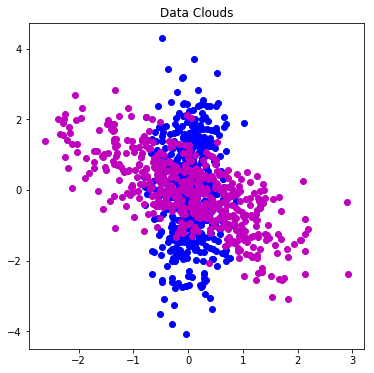



We can compare the OR conceptor (red) to the conceptor from the union (black)


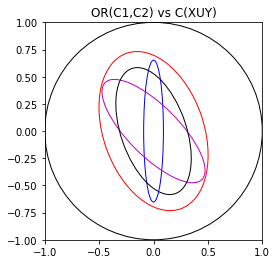

We can also examine their eigenvalues/eigenvectors 

Eigenvalues of OR(C1,C2)
[0.46202526 0.7573926 ] 

Eigenvalues of C(XUY)
[0.30034012 0.60918862] 

Eigenvectors of OR(C1,C2)
[[-0.94533076  0.32611311]
 [-0.32611311 -0.94533076]] 

Eigenvectors of C(XUY)
[[-0.94490343  0.3273492 ]
 [-0.3273492  -0.94490343]] 

Note that they have the same eigenvectors but differently scaled eigenvalues
In this case, OR and Unions behave mostly similarly, however this changes if
we don't constrain that |X| = |Y|

Let's examine a case where |X| != |Y|


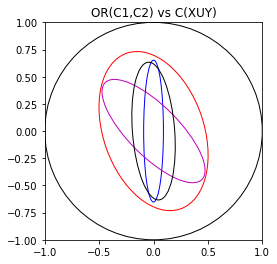


In this case, it is clear that the conceptor from the union is somwhere between
 C1 and C2, however it no longer weights them equally as the OR operation does 


In [0]:
################################################################################
## First we consider the case where |X| = |Y|                                 ##
################################################################################
# We use the data computed in the previous section again, but we will plot it 
# once again as a reminder
print('First we consider the case where |X| = |Y|')
plt.figure(figsize=(6,6))
plt.title('Data Clouds')
plt.scatter(X[0][::100],X[1][::100], c = 'b')
plt.scatter(Y[0][::100],Y[1][::100], c = 'm')
plt.show()
print("\n")

# We have already compute the conceptors for these datasets to be C1 and C2
# so all that remains is the calculate the conceptor from their union the
# conceptor from the OR operation
C1_or_C2 = OR(C1,C2)
C1UC2 = get_conceptor(np.hstack((X,Y)), 1)

print('We can compare the OR conceptor (red) to the conceptor from the union (black)')
ax = plt.subplot(111, aspect = 'equal')

ell1 = CtoE(C1, color = 'b')
ell2 = CtoE(C2, color = 'm')
ellOR = CtoE(C1_or_C2, color = 'r')
ellU = CtoE(C1UC2, color = 'k')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(ellOR)
ax.add_artist(ellU)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title('OR(C1,C2) vs C(XUY)')
plt.show()


################################################################################
## We can also examine their eigenvalues and eigenvectors                     ##
################################################################################
eig_OR,vec_OR = np.linalg.eig(C1_or_C2)
eig_U,vec_U = np.linalg.eig(C1UC2)

print('We can also examine their eigenvalues/eigenvectors \n')
print('Eigenvalues of OR(C1,C2)')
print(eig_OR, '\n')
print('Eigenvalues of C(XUY)')
print(eig_U, '\n')
print('Eigenvectors of OR(C1,C2)')
print(vec_OR, '\n')
print('Eigenvectors of C(XUY)')
print(vec_U, '\n')
print('Note that they have the same eigenvectors but differently scaled eigenvalues')
print('In this case, OR and Unions behave mostly similarly, however this changes if')
print('we don\'t constrain that |X| = |Y|')


################################################################################
## Consider |X| != |Y|                                                        ##
################################################################################
C1 = get_conceptor(X,1)
C2 = get_conceptor(Y[:,:10000],1)
C1_or_C2 = OR(C1,C2)
C1UC2 = get_conceptor(np.hstack((X,Y[:,:10000])),1)

print('\nLet\'s examine a case where |X| != |Y|')
ax = plt.subplot(111, aspect = 'equal')

ell1 = CtoE(C1, color = 'b')
ell2 = CtoE(C2, color = 'm')
ellOR = CtoE(C1_or_C2, color = 'r')
ellU = CtoE(C1UC2, color = 'k')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(ellOR)
ax.add_artist(ellU)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title('OR(C1,C2) vs C(XUY)')
plt.show()
print('\nIn this case, it is clear that the conceptor from the union is somwhere between\n',
      'C1 and C2, however it no longer weights them equally as the OR operation does ')

# 3) Covariance vs Correlation In Computing Conceptors

## Distributions Without Standardized Mean/Variance
Whilst covariance and correlation are the same when distributions have zero mean and unit variance, not all data follows this. Therefore, we should check which is better for computing conceptors in the case that a pattern does not have zero mean or unit variance. It is clear here that
covariance is the better way to compute conceptors.


First we introduce some data clouds


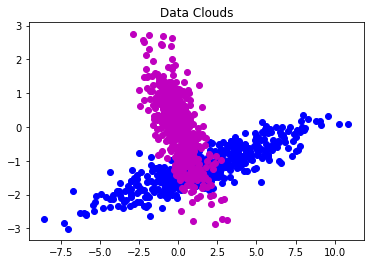



Then we can compare conceptors traiend on Covariance matrices and conceptors
trained on Correlation matrices as well as our original conceptor implementation


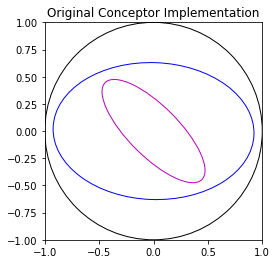

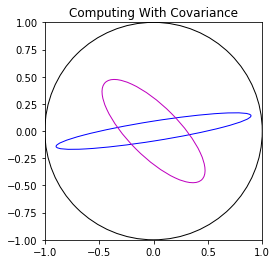

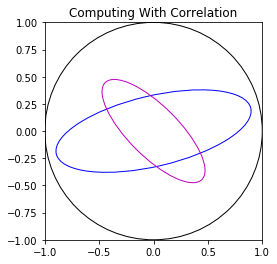

Whilst the two methods are the same in the standardized mean/variance case,
we can see that the covariance method puts out better results when this
assumption is false


In [0]:
# First lets modify our definition of the conceptor to be applicable to non
# standardized mean/variance. We present two implementation (one that uses 
# covariance and the other which utilized correlation)
def improved_conceptor(X, alpha = 1):
    N = X.shape[1] 
    means = np.mean(X, axis = 1)
    X = X - means[:,None]
    cov = (X @ X.T)*(1/N)
    return cov @ inv(cov + (alpha**(-2))*np.eye(X.shape[0]))

def corr_conceptor(X, alpha = 1):
    N = X.shape[1] 
    means = np.mean(X, axis = 1)
    std = np.sqrt(np.var(X, axis = 1))
    X = X - means[:,None]/std[:,None]
    cov = (X @ X.T)*(1/N)
    return cov @ inv(cov + (alpha**(-2))*np.eye(X.shape[0]))

print('First we introduce some data clouds')
N = 50000
r = -np.pi/5
rot = [[np.cos(r), -np.sin(r)],[np.sin(r),np.cos(r)]]
X = np.random.multivariate_normal([2,0], [[5,4.9],
                                         [4.9,5]],N).T
Y = np.random.multivariate_normal([0,0],[[1,-0.7],
                                         [-0.7,1]],N).T

X = rot @ X
plt.title('Data Clouds')
plt.scatter(X[0][::100],X[1][::100], c = 'b')
plt.scatter(Y[0][::100],Y[1][::100], c = 'm')
plt.show()
print("\n")

print('Then we can compare conceptors traiend on Covariance matrices and conceptors')
print('trained on Correlation matrices as well as our original conceptor implementation')

## Original Conceptor Implementation
C1 = get_conceptor(X,1)
C2 = get_conceptor(Y,1)

ax = plt.subplot(111, aspect = 'equal')

ell1 = CtoE(C1, color = 'b')
ell2 = CtoE(C2, color = 'm')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title('Original Conceptor Implementation')
plt.show()

## Conceptors Computed With Covariance
C1 = improved_conceptor(X)
C2 = improved_conceptor(Y)

ax = plt.subplot(111, aspect = 'equal')

ell1 = CtoE(C1, color = 'b')
ell2 = CtoE(C2, color = 'm')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title('Computing With Covariance')
plt.show()

## Conceptors Computed With Correlation
C1 = corr_conceptor(X)
C2 = corr_conceptor(Y)

ax = plt.subplot(111, aspect = 'equal')

ell1 = CtoE(C1, color = 'b')
ell2 = CtoE(C2, color = 'm')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.title('Computing With Correlation')
plt.show()

print('Whilst the two methods are the same in the standardized mean/variance case,')
print('we can see that the covariance method puts out better results when this')
print('assumption is false')

# 4) Understanding the $\alpha$ Hyperparameter

In this section we attempt to get a better understaning of what value of $\alpha$ is optimal. We can observe that good alpha lie with the range 0.1 - 10. However, we do not have a way to calculate optimal $\alpha$ other than by computing the conceptors for different $\alpha$ and comparing their performances. We can also note that at high values of $\alpha$, $C$ becomes a zero matrix and at low values of $\alpha$, $C$ becomes the identity matrix, therefore we should expect an optimal value of alpha to be near 1.

First we generate a dataset of data from a multivariate normal
Covariance Matrix of Data
[[ 1.3  0.8  0.4 -0.6 -0.1 -1.6  1.5  0.3  1.5  0.7]
 [ 0.8  1.1  0.2 -0.4  0.  -1.   1.1  0.1  1.   0.3]
 [ 0.4  0.2  0.5 -0.1 -0.1 -0.5  0.6  0.1  0.6  0.3]
 [-0.6 -0.4 -0.1  0.6  0.2  1.  -1.  -0.1 -0.7 -0.3]
 [-0.1  0.  -0.1  0.2  0.3  0.  -0.   0.1 -0.1 -0.1]
 [-1.6 -1.  -0.5  1.   0.   3.  -2.7 -0.4 -2.5 -0.8]
 [ 1.5  1.1  0.6 -1.  -0.  -2.7  3.6  0.5  2.6  1. ]
 [ 0.3  0.1  0.1 -0.1  0.1 -0.4  0.5  0.6  0.5 -0. ]
 [ 1.5  1.   0.6 -0.7 -0.1 -2.5  2.6  0.5  2.9  0.8]
 [ 0.7  0.3  0.3 -0.3 -0.1 -0.8  1.  -0.   0.8  0.6]]


A well parametrized conceptor can be used to debias data so its correlation
matrix becomes close to the identity. 

Correlation of negated data at alpha = 1
[[ 1.   0.2  0.1 -0.  -0.1  0.  -0.3  0.2 -0.1  0.4]
 [ 0.2  1.  -0.  -0.   0.1  0.1 -0.1 -0.1 -0.1 -0.2]
 [ 0.1 -0.   1.   0.2 -0.2  0.1 -0.   0.1 -0.   0.2]
 [-0.  -0.   0.2  1.   0.3  0.1 -0.  -0.   0.3  0.1]
 [-0.1  0

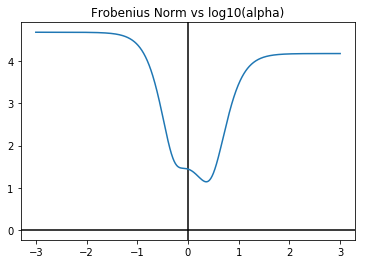

In this case, the optimal alpha is  2.27697025538168
Unbiasing at this alphas results in the following correlation matrix
[[ 1.  -0.1 -0.2  0.1 -0.   0.2 -0.2  0.1 -0.2  0.1]
 [-0.1  1.   0.1  0.   0.   0.1 -0.1 -0.  -0.1 -0.1]
 [-0.2  0.1  1.   0.   0.  -0.  -0.1  0.  -0.1 -0.1]
 [ 0.1  0.   0.   1.   0.  -0.2  0.1 -0.  -0.   0. ]
 [-0.   0.   0.   0.   1.  -0.  -0.   0.  -0.   0.1]
 [ 0.2  0.1 -0.  -0.2 -0.   1.   0.3  0.1  0.3  0.1]
 [-0.2 -0.1 -0.1  0.1 -0.   0.3  1.  -0.  -0.3 -0.1]
 [ 0.1 -0.   0.  -0.   0.   0.1 -0.   1.  -0.1 -0.1]
 [-0.2 -0.1 -0.1 -0.  -0.   0.3 -0.3 -0.1  1.  -0.1]
 [ 0.1 -0.1 -0.1  0.   0.1  0.1 -0.1 -0.1 -0.1  1. ]]


In [0]:
%precision 1
np.set_printoptions(suppress=True)
################################################################################
## First we create a dataset from a multivariate normal with randomized       ##
## covariance matrix parameters                                               ##
################################################################################
samples = 50000
dim = 10
cov = random_semipositivedefinite(dim)

print('First we generate a dataset of data from a multivariate normal')
print('Covariance Matrix of Data')
print(cov)
print('\n')

X = np.random.multivariate_normal(np.zeros(dim),cov,10000).T
notC = NOT(improved_conceptor(X,1))
unbiased = np.matmul(notC,X)

print('A well parametrized conceptor can be used to debias data so its correlation')
print('matrix becomes close to the identity. \n')
print('Correlation of negated data at alpha = 1')
print(corr(unbiased))
print('\n')

print('We can visualize the effectiveness of the conceptors at different alpha')
print('by taking the Frobenius norm of the unbiased data\'s correlation matrix')
print('and the identity matrix of appropriate dimension')

alphas = np.linspace(-3,3,1000)
alphas = np.power(10,alphas)

z = np.zeros(1000)
min_alpha = 1000
min_z = 10000
print(min_alpha,min_z)
for i in range(1000):
    notC = NOT(get_conceptor(X,alphas[i]))
    unbiased = np.matmul(notC,X)
    correlation = corr(unbiased)
    z[i] = np.linalg.norm(np.identity(dim)-correlation)
    if z[i] < min_z:
        min_alpha = alphas[i]
        min_z = z[i]
    
            
alphas = np.log10(alphas)
ax = plt.subplot(111)
ax.axvline(c = 'k')
ax.axhline(c = 'k')
ax.plot(alphas,z)

plt.title('Frobenius Norm vs log10(alpha)')
plt.show()

print('In this case, the optimal alpha is ', min_alpha)
print('Unbiasing at this alphas results in the following correlation matrix')
notC = NOT(get_conceptor(X,min_alpha))
unbiased = notC @ X
print(corr(unbiased))

# Conceptors on Non-Ellipsoid Distributions

One potential weakness of the conceptor matrix approach to debiasing is that it assumes that the data follows a distribution that is well approximated by an ellipse. In this section we examine what happens when that is not the case. We observe that conceptors do not have
the ability to transform the underlying geometry (since they are a linear transformation), but they still perform well at bringing the correlation matrix closer to the identity in all cases except for when the data has some sort of linear geometry (ex. diagonally spaced clusters).

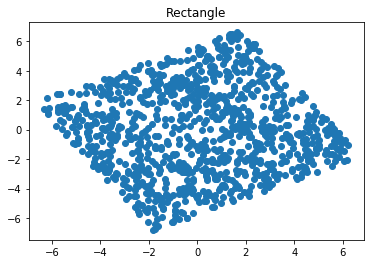

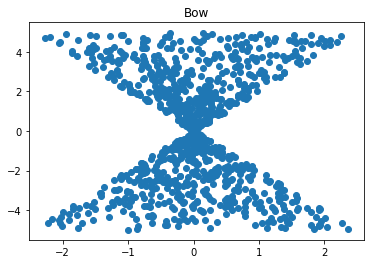

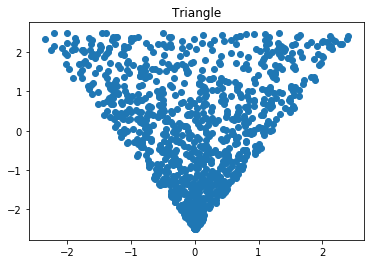

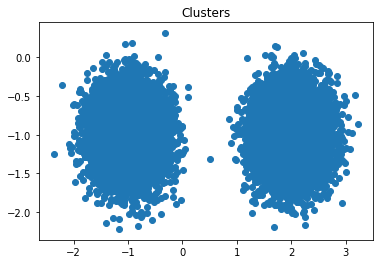

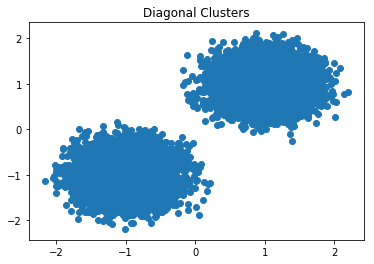

In [0]:
################################################################################
## First we generate some datasets to work with                               ##
################################################################################

# Rectanglular Data Cloud
rotation = np.pi/6
rot = [[np.cos(rotation),-np.sin(rotation)],
       [np.sin(rotation),  np.cos(rotation)]]
sz = 5
samples = 1000

rectangle = np.random.uniform(-sz,sz,(2,samples))
rectangle = rot @ rectangle

plt.title('Rectangle')
plt.scatter(rectangle[0],rectangle[1])
plt.show()

# Bow Data Cloud
rotation = np.pi/2
rot = [[np.cos(rotation),-np.sin(rotation)],
       [np.sin(rotation),  np.cos(rotation)]]

sz = 5
samples = 1000
bow = np.random.uniform(-sz,sz,(2,samples))
bow[1] = bow[1]*bow[0]/(2*sz)
bow = rot @ bow

plt.title('Bow')
plt.scatter(bow[0],bow[1])
plt.show()

# Triangular Data Cloud

rotation = np.pi/2
rot = [[np.cos(rotation),-np.sin(rotation)],
       [np.sin(rotation),  np.cos(rotation)]]

sz = 5
samples = 1000
triangle = np.random.uniform(-sz,sz,(2,samples))
triangle[1] = triangle[1]*triangle[0]/(2*sz)
triangle[0] = abs(triangle[0])
triangle = triangle - np.mean(triangle,axis=1)[:,None]
triangle = rot @ triangle

plt.title('Triangle')
plt.scatter(triangle[0],triangle[1])
plt.show()

## Cluster Data Cloud
cluster1 = np.random.multivariate_normal([2,-1],[[0.1,0],
                                      [0,0.1]],10000).T
cluster2 = np.random.multivariate_normal([-1,-1],[[0.1,0],
                                      [0,0.1]],10000).T
cluster = np.hstack((cluster1,cluster2))

plt.title('Clusters')
plt.scatter(cluster[0],cluster[1])
plt.show()

## Diagonal Data Cloud
cluster1 = np.random.multivariate_normal([1,1],[[0.1,0],
                                      [0,0.1]],10000).T
cluster2 = np.random.multivariate_normal([-1,-1],[[0.1,0],
                                      [0,0.1]],10000).T
diagonal = np.hstack((cluster1,cluster2))

plt.title('Diagonal Clusters')
plt.scatter(diagonal[0],diagonal[1])
plt.show()

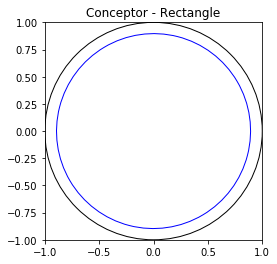

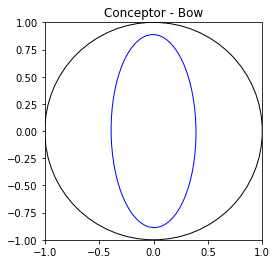

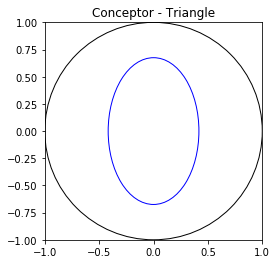

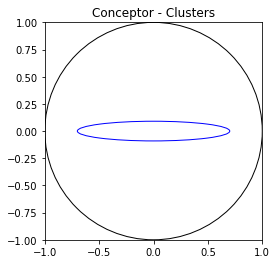

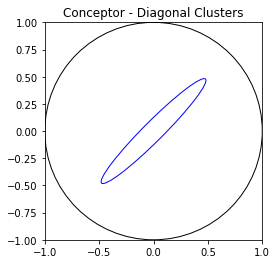

In [0]:
################################################################################
## Now we can compute and plot Conceptors                                     ##
################################################################################

Cr = improved_conceptor(rectangle)
Cb = improved_conceptor(bow)
Ct = improved_conceptor(triangle)
Cc = improved_conceptor(cluster)
Cd = improved_conceptor(diagonal)

# Plot Rectangle
ax = plt.subplot(111, aspect = 'equal')
plt.title('Conceptor - Rectangle')
ell = CtoE(Cr, color = 'b')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

# Plot Bow
ax = plt.subplot(111, aspect = 'equal')
plt.title('Conceptor - Bow')
ell = CtoE(Cb, color = 'b')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

# Plot Triangle
ax = plt.subplot(111, aspect = 'equal')
plt.title('Conceptor - Triangle')
ell = CtoE(Ct, color = 'b')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

# Plot Clusters
ax = plt.subplot(111, aspect = 'equal')
plt.title('Conceptor - Clusters')
ell = CtoE(Cc, color = 'b')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

# Plot Diagonal Clusters
ax = plt.subplot(111, aspect = 'equal')
plt.title('Conceptor - Diagonal Clusters')
ell = CtoE(Cd, color = 'b')
circ = CtoE(np.eye(2), color = 'k')

ax.add_artist(ell)
ax.add_artist(circ)

plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

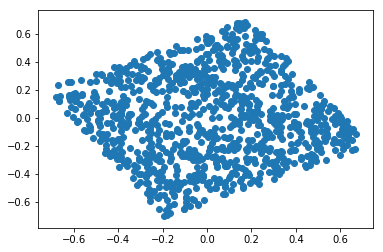

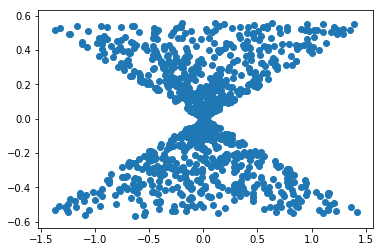

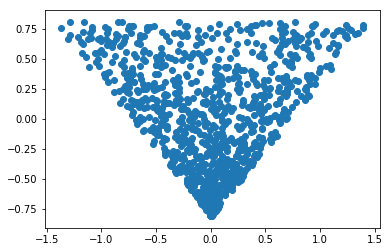

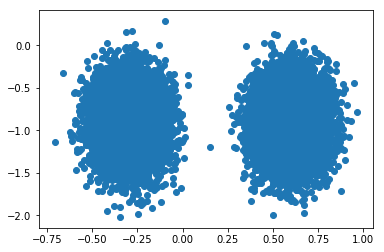

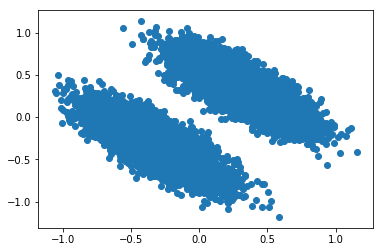

Correlation for Debiased Rectangle
[[ 1. -0.]
 [-0.  1.]] 

Correlation for Debiased Bow
[[1. 0.]
 [0. 1.]] 

Correlation for Debiased Triangle
[[ 1. -0.]
 [-0.  1.]] 

Correlation for Debiased Clusters
[[ 1. -0.]
 [-0.  1.]] 

Correlation for Debiased Diagonal Clusters
[[1.  0.5]
 [0.5 1. ]] 



In [0]:
################################################################################
## Now we can see how they transform data                                     ##
################################################################################
Cr = improved_conceptor(rectangle)
Cb = improved_conceptor(bow)
Ct = improved_conceptor(triangle)
Cc = improved_conceptor(cluster)
Cd = improved_conceptor(diagonal)

notR = NOT(Cr)
notB = NOT(Cb)
notT = NOT(Ct)
notC = NOT(Cc)
notD = NOT(Cd)

unbiasedR = notR @ rectangle
unbiasedB = notB @ bow
unbiasedT = notT @ triangle
unbiasedC = notC @ cluster
unbiasedD = notD @ diagonal

plt.scatter(unbiasedR[0],unbiasedR[1])
plt.show()
plt.scatter(unbiasedB[0],unbiasedB[1])
plt.show()
plt.scatter(unbiasedT[0],unbiasedT[1])
plt.show()
plt.scatter(unbiasedC[0],unbiasedC[1])
plt.show()
plt.scatter(unbiasedD[0],unbiasedD[1])
plt.show()

################################################################################
## We can also see the associated correlation matrices for the debiased sets  ##
################################################################################
print('Correlation for Debiased Rectangle')
print(corr(unbiasedR), '\n')
print('Correlation for Debiased Bow')
print(corr(unbiasedB), '\n')
print('Correlation for Debiased Triangle')
print(corr(unbiasedT), '\n')
print('Correlation for Debiased Clusters')
print(corr(unbiasedC), '\n')
print('Correlation for Debiased Diagonal Clusters')
print(corr(unbiasedD), '\n')